In [387]:
import numpy as np
import scipy
import networkx as nx   
import matplotlib.pyplot as plt  

plt.rcParams['figure.figsize'] = [10, 8]
import matplotlib.ticker as ticker

from matplotlib.legend_handler import HandlerTuple
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib.animation import FuncAnimation
rc('axes', linewidth=3)
rc('text', usetex=True)
rc('font', size=26, family='serif', weight='bold')
rc('lines',linewidth=3,color='blue')
rc('xtick.major', pad=10, size=5, width=3)
rc('ytick.major', pad=10, size=5, width=3)

In [388]:
# Bounds as a function of time
cnt=40
j=0
data = np.zeros((cnt,13))

assmpn_data = np.zeros((cnt,3))

scnt=50
n = 100
k = 6
diff=25
total_size=2*n-diff+k
block_size = n+3 #=n+k/2
full_spectrum =np.zeros((scnt, total_size))
S_spectrum =np.zeros((scnt, block_size))
Sbar_spectrum =np.zeros((scnt, block_size-diff))

#rand_perturb=np.diag(np.random.rand(total_size)*1e-5)


G1 = nx.complete_graph(n)

G2 = nx.complete_graph(n-diff)
G3 = nx.path_graph(k)
G = nx.disjoint_union(G1,G3)
G = nx.disjoint_union(G, G2)
A = nx.adjacency_matrix(G).todense()
A[n-1,n] = w
A[n,n-1] = w

A[n+k-1,n+k] = w
A[n+k,n+k-1] = w


w = 5

A[block_size,block_size-1] = w
A[block_size-1,block_size] = w

A[block_size-1,block_size-2] = w
A[block_size-2,block_size-1] = w

A[block_size+1,block_size] = w
A[block_size,block_size+1] = w

A[block_size+2,block_size+1] = w
A[block_size+1,block_size+2] = w

A[block_size-2,block_size-3] = w
A[block_size-3,block_size-2] = w

A[block_size+3,block_size+2] = w
A[block_size+2,block_size+3] = w

A[block_size-3,block_size-4] = w
A[block_size-4,block_size-3] = w

#print(A)
V1 = np.zeros([total_size,total_size])
V1[0,0] = -2.0
V1[total_size-1,total_size-1] = -2.0

 
for T in np.logspace(-3,6,cnt):       
    data[j,0] = T
    data[j,1] = 1000 #will store min gap
    data[j,2] = 0 #will store min gap s value
    data[j,3] = 1000 #will store min gap, S
    data[j,4] = 0 #will store min gap s value, S
    data[j,5] = 1000 #will store min gap, Sbar
    data[j,6] = 0 #will store min gap s value, Sbar
    data[j,10] = 0 #will store max B 
    data[j,11] = 0 #will store max C/eta
    
    assmpn_data[j,0] = 0 #will store maximum h
    assmpn_data[j,1] = 0 #will store max assmpn3 term
    assmpn_data[j,2] = 0 #will store max assmpn4 term
    
    refbnd_term1=0
    refbnd_term2=0
    refbnd_term3=0
    
    hmax = 0
    assm3term_max = 0
    assm4term_max = 0
    
    maxB = 0
    maxCOverEtaT = 0
    
    cntr = 0
    for s in np.linspace(0.0,1.0,scnt):
        H=-A+s*V1
        Hdot = V1
        Hdotdot = 0
        normHdot = scipy.linalg.norm(Hdot)
        normHSdot = scipy.linalg.norm(Hdot[:block_size,:block_size])
        normHSbardot = scipy.linalg.norm(Hdot[block_size:,block_size:])
        
        evals,evecs=scipy.linalg.eigh(H)
        gs = evecs[:,0]
        gap = evals[1]-evals[0]
        if(gap<data[j,1]):
            data[j,1]=gap
            data[j,2]=s


        projgs = np.zeros(total_size)
        projgsbar = np.zeros(total_size)
        projgs[:block_size] = gs[:block_size]
        projgsbar[:block_size] = gs[:block_size]


        #get subspace Hamiltonians
        HS = H[:block_size,:block_size]
        HSbar = H[block_size:,block_size:]
        Delta = H[:block_size,block_size:]
        DeltaConj = H[block_size:,:block_size]
        evalsS,evecsS = scipy.linalg.eigh(HS)
        evalsSbar,evecsSbar = scipy.linalg.eigh(HSbar)
        gsS = np.zeros(total_size)
        gsS[:block_size] = evecsS[:,0]
        gsSbar = np.zeros(total_size)
        gsSbar[block_size:] = evecsSbar[:,0]

        

        
        #get our bound------------------------------------
        #Step 1: get Cheeger constant

        DeltaLarge = np.zeros((total_size,total_size))
        DeltaLarge[:block_size,block_size:]=Delta
        DeltaLarge[block_size:,:block_size]=DeltaConj
        h = -1*np.inner(gs,DeltaLarge@projgs)/(np.min([np.inner(projgs,gs)**2,np.inner(projgsbar,gs)**2]) )
        
        #get gammaS, gammaSbar
        gammaS = evalsS[1]-evalsS[0]
        gammaSbar = evalsSbar[1]-evalsSbar[0]
        
        #get normDeltaperp, and related quantities
        localGap = np.min([gammaS,gammaSbar])
        c = scipy.linalg.norm(DeltaLarge)/localGap
        #Deltadot = 0 in this example
        Pmu = np.outer(gsS,gsS)
        Pmubar = np.outer(gsSbar,gsSbar)
        DeltaPerp = (np.eye(total_size)-Pmu-Pmubar)@DeltaLarge@(np.eye(total_size)-Pmu-Pmubar)
        normDeltaPerp = scipy.linalg.norm(DeltaPerp)
        eta = 1-normDeltaPerp/localGap
        
        temp=0
        if evals[-1]-evals[0]<=2*h:
            print("NO HES")
            lesGap=1e8
        else:
            for e in evals:
                if e > evals[0] + 2*h:
                    break
                temp+=1
            lesGap = evals[temp]-evals[0]-2*h
        
        
        #get epsilont
        term1 = normHdot/lesGap**2/T #usual "folklore adiabatic theorem" for gap between les and hes
        C2 = 2*normHSdot/gammaS**2+2*normHSbardot/gammaSbar**2
        term2 = C2/eta/T #local first order term
        epsilonT = np.min([1, np.max([term1,term2])])
     
        
        #get kappa
        kappa = evals[total_size-1]-evals[0]
        
        assm3term = kappa/(1-c)/localGap
        assm4term = epsilonT*np.sqrt(kappa)
        
        B = 2*np.sqrt(1+2*np.sqrt(assm3term)+assm4term/np.sqrt(h))
        if (B>maxB):
            maxB = B
        C = normHSdot/gammaS**2 #folklore version
        
        
        if (C/eta/T > maxCOverEtaT):
            maxCOverEtaT = C/eta/T
        
        if(h>hmax):
            hmax = h
        if(assm3term>assm3term_max):
            assm3term_max = assm3term
        if(assm4term>assm4term_max):
            assm4term_max = assm4term

        #---------------------------------------------------------
        #naive perturbation theory bound, use "folklore" local adiabatic bound
        gapS = evalsS[1]-evalsS[0]
        gapSbar = evalsSbar[1]-evalsSbar[0]
        if(gapS<data[j,3]):
            data[j,3]=gapS
            data[j,4]=s
        if(gapSbar<data[j,5]):
            data[j,5]=gapSbar
            data[j,6]=s
        
        refbnd_term1_temp = scipy.linalg.norm(DeltaLarge@gsS)
        #these are the terms that blow up
        refbnd_term2_temp = scipy.linalg.norm(DeltaLarge)*(1/gapS**2)*normHSdot
        refbnd_term3_temp = scipy.linalg.norm(DeltaLarge)*(1/gapS**2)*normHSdot/T
                
        if(refbnd_term1_temp>refbnd_term1):
            refbnd_term1 = refbnd_term1_temp
        if(refbnd_term2_temp>refbnd_term2):
            refbnd_term2 = refbnd_term2_temp
        if(refbnd_term3_temp>refbnd_term3):
            refbnd_term3 = refbnd_term3_temp

        full_spectrum[cntr,:] = evals
        S_spectrum[cntr,:] = evalsS
        Sbar_spectrum[cntr,:] = evalsSbar
        cntr+=1
        
        #True error----------------------------------
    
    #assmpn data
    assmpn_data[j,0] = hmax
    assmpn_data[j,1] = assm3term_max
    assmpn_data[j,2] = assm4term_max
    
    
    #ratio between global gap and local gap
    data[j,7] = data[j,1]/np.min([data[j,3],data[j,5]])
    #our bound
    data[j,10] = maxB*np.sqrt(hmax*T)
    data[j,11] = maxCOverEtaT
    data[j,8] = maxB*np.sqrt(hmax*T)+maxCOverEtaT
    #naive bound
    data[j,9] = 2*np.sqrt(refbnd_term1*T)+2*np.sqrt(refbnd_term2)+refbnd_term3
    #standard adiabatic error
    data[j,12] = normHdot/data[j,1]**2/T
    j+=1
    
np.set_printoptions(precision=3,suppress=False)
#print(data[:,1],data[:,3])

#print(epsilonT)

#print(scipy.linalg.norm(DeltaLarge))

[0.271 0.16  0.094 0.056 0.033 0.02  0.012 0.008 0.005 0.003 0.002 0.002
 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.002 0.002 0.002 0.003 0.003 0.004 0.005 0.007 0.009
 0.011 0.015 0.019 0.025]


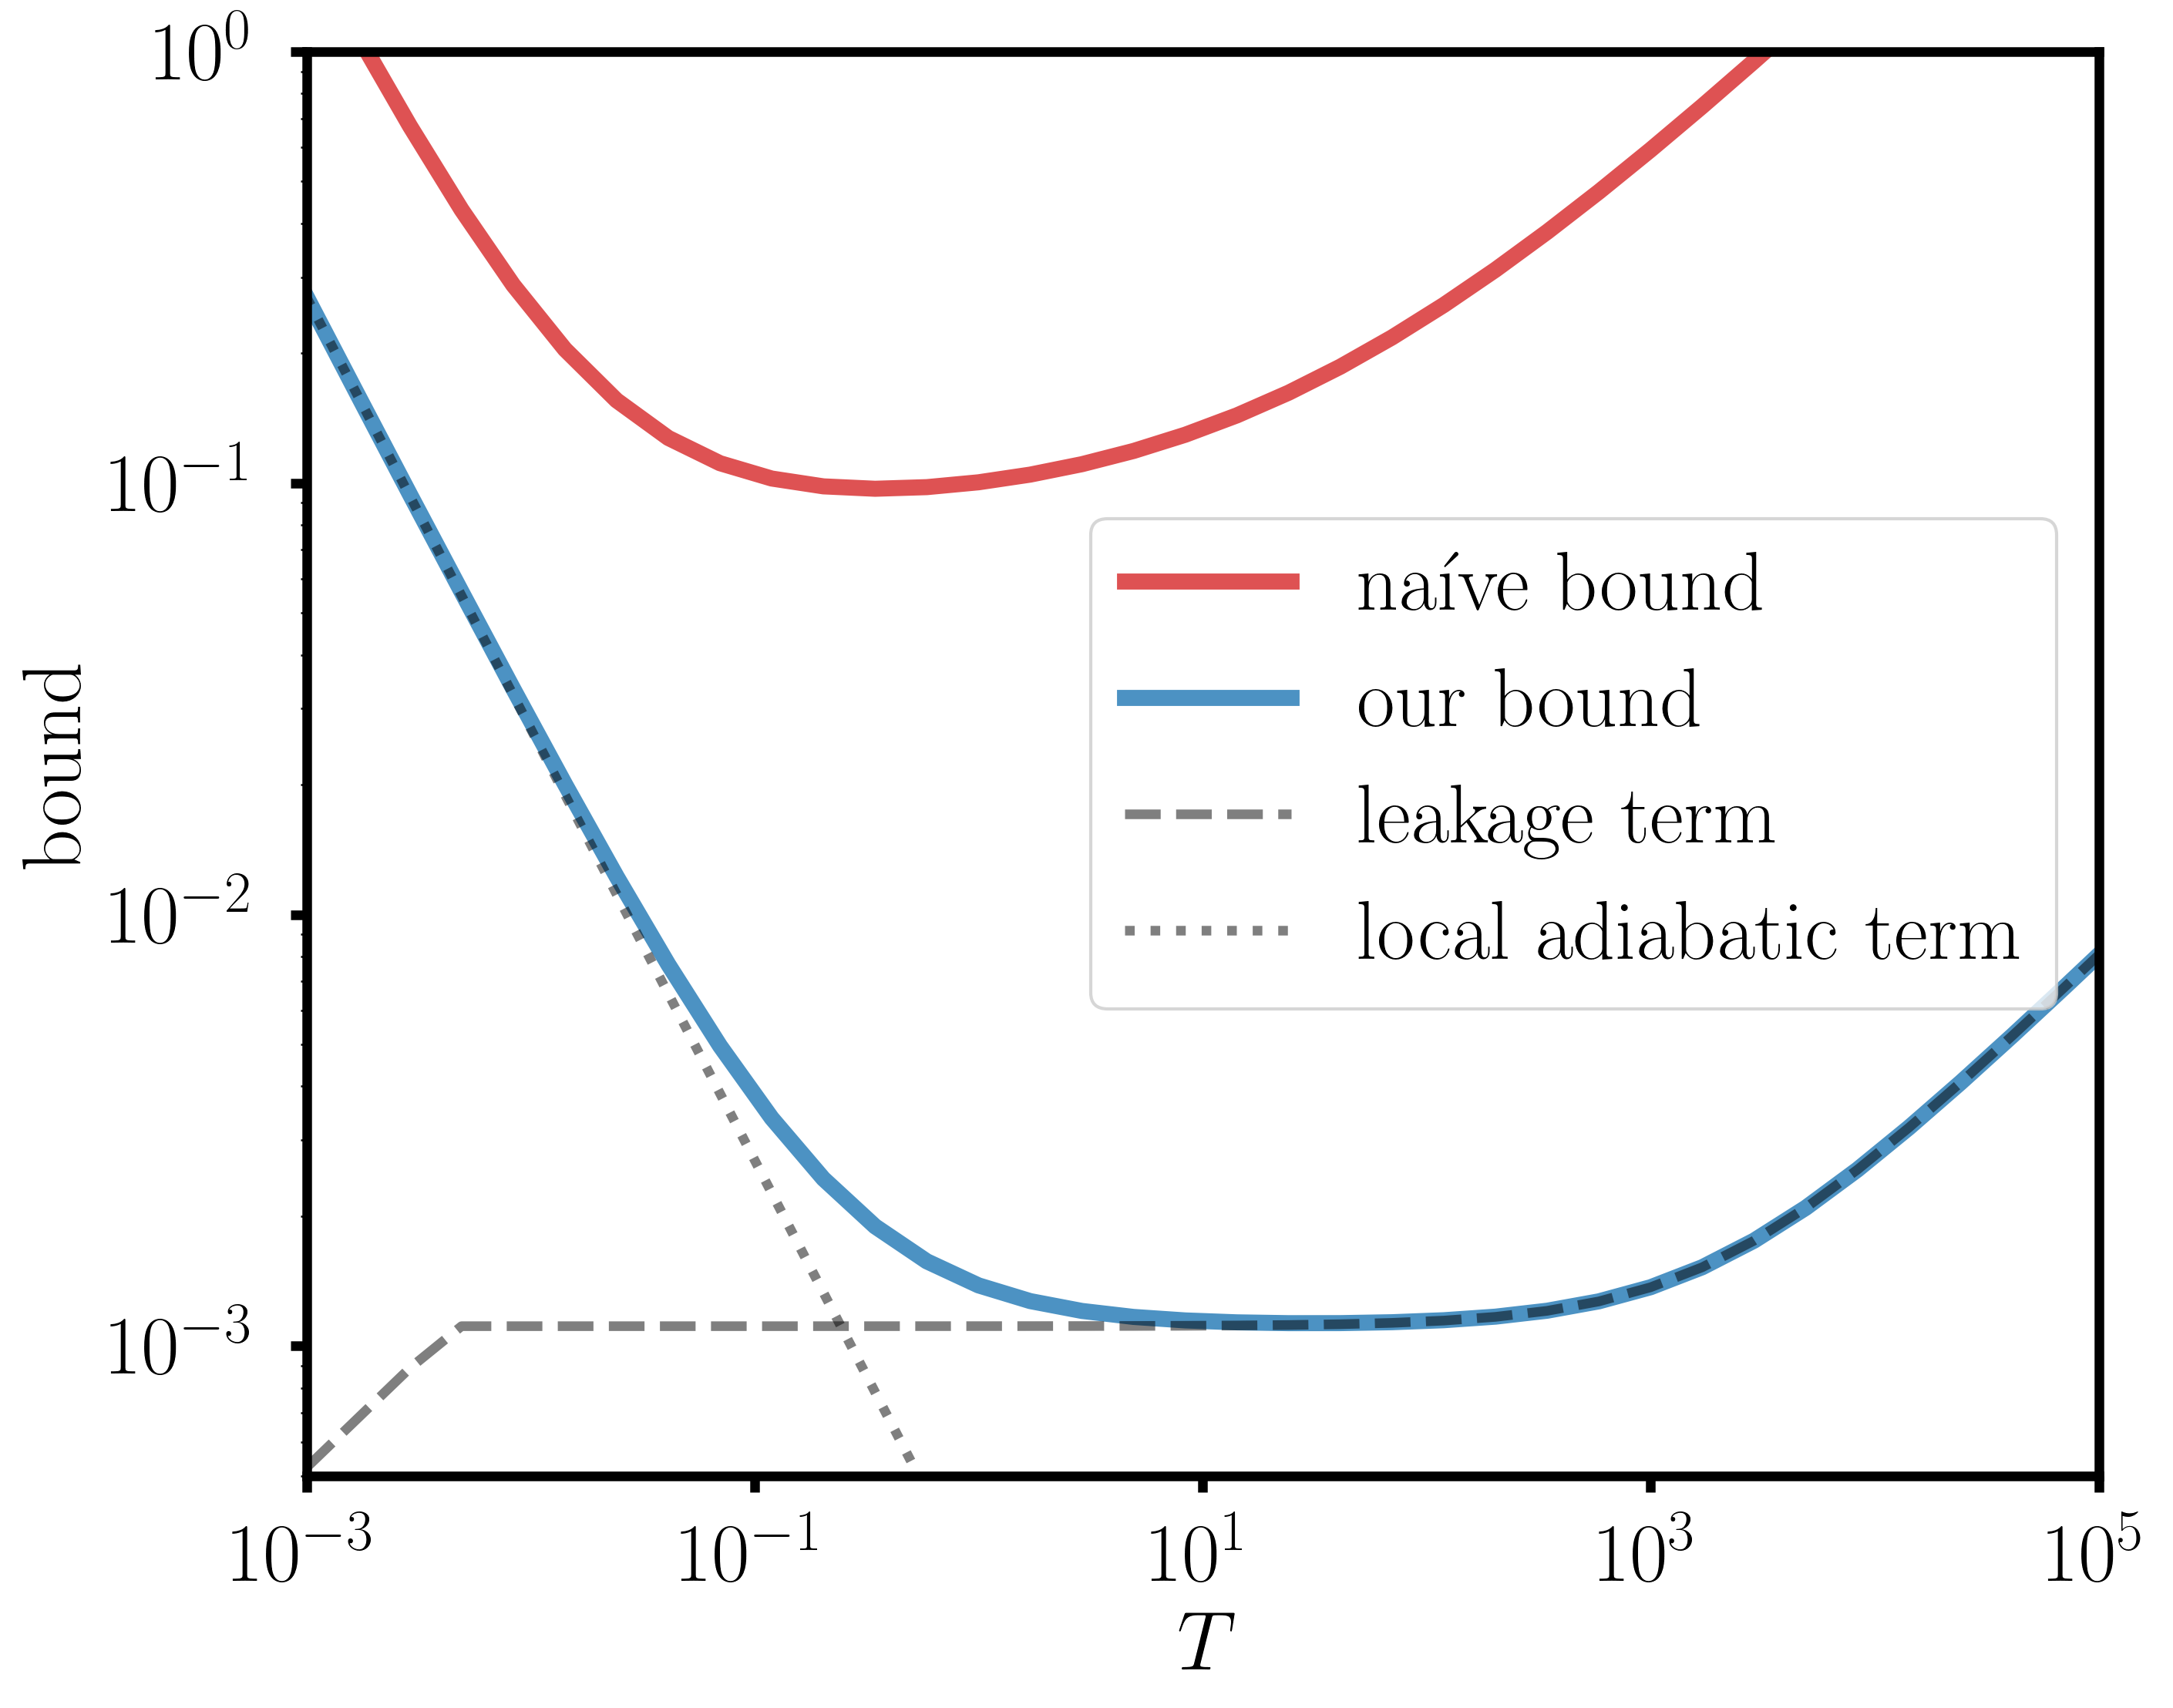

In [389]:
#plot bounds vs. T, n=100
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(1, 1, 1)

colors = plt.colormaps["tab10"]


ax.plot(data[:,0],data[:,9], label=r"na\'ive bound", linewidth=5, alpha=0.8, color=colors(0.3))
ax.plot(data[:,0],data[:,8], label=r"our bound", linewidth=5, alpha=0.8, color=colors(0.0))

ax.plot(data[:,0],data[:,10],'--', color="k", label=r"leakage term", alpha=0.5, linewidth=3)
ax.plot(data[:,0],data[:,11],':', color="k", label=r"local adiabatic term", alpha=0.5, linewidth=3)


ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='center right')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'bound')

ax.set_ylim([5e-4,1])
ax.set_xlim([1e-3,1e5])

print(data[:,8])